# Mount my drive:

In [1]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir('drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Binary_activations_V2/MNIST_Binary_V2')
!ls

config.py   distributions  README.md	     trained_models
data	    experiments    requirements.txt  utils
DataLoader  __pycache__    results	     visualize


# Import:

In [0]:
!pip install pytorch-ignite

     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
try:
  from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
  from ignite.metrics import Accuracy, Loss, ConfusionMatrix
  from ignite.handlers import ModelCheckpoint
  from utils.training import run, evaluate
except ImportError:
  raise RuntimeError("no module Ignite, to install Ignite: 'pip install pytorch-ignite'.")

from tqdm import tqdm

In [0]:
import torch
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

from utils.models import get_my_model_MNIST, fetch_last_checkpoint_model_filename
from DataLoader.dataLoaders import get_mnist_dataloaders
from utils.functions import Hardsigmoid

In [0]:
from visualize.viz import visTensor, get_activation, viz_activations, viz_filters
from visualize.viz import viz_heatmap, test_predict_few_examples, standardize_and_clip, format_for_plotting
from visualize.viz import apply_transforms, GradientAscent, get_filter_layer2, get_labels_histogram
from visualize.viz import get_region_layer1, get_region_layer2, get_regions_interest, get_all_regions_max
from visualize.viz import compare_two_histograms,viz_regions
from torchvision import datasets, transforms

# for regions extraction
import collections
from functools import partial
import cv2

# Load models and data:

In [5]:
batch_size_train = 60000
batch_size_test = 1000
# Dataset
train_loader, valid_loader, test_loader, classes = get_mnist_dataloaders(batch_size_train, batch_size_test)

Number of validation examples: 6000
Number of training examples: 1
Number of testing examples: 10


In [6]:
# load model pre trained no binary
binary = False
maxpooling = False

model_no_binary_stride, name_model = get_my_model_MNIST(binary, maxpooling=maxpooling)

path_model = 'trained_models/MNIST/No_binary_models/with_bias/stride'
if torch.cuda.is_available():
  model_no_binary_stride.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model)))
else:
  model_no_binary_stride.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model), map_location=torch.device('cpu')))
print("Model Loaded", name_model)

Model Loaded MNIST_NonBinaryNet


In [7]:
# load model pre trained no binary
binary = False
maxpooling = True

model_no_binary_maxpooling, name_model = get_my_model_MNIST(binary, maxpooling=maxpooling)

path_model = 'trained_models/MNIST/No_binary_models/with_bias/maxpooling'
if torch.cuda.is_available():
  model_no_binary_maxpooling.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model)))
else:
  model_no_binary_maxpooling.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model), map_location=torch.device('cpu')))
print("Model Loaded", name_model)

Model Loaded MNIST_NonBinaryNet_maxpooling


In [8]:
# load model pre trained binary
binary = True    
maxpooling = False
model_binary_stride, name_model = get_my_model_MNIST(binary, maxpooling=maxpooling)

path_model = 'trained_models/MNIST/Binary_models/with_bias/stride'
if torch.cuda.is_available():
  model_binary_stride.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model)))
else:
  model_binary_stride.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model), map_location=torch.device('cpu')))
print("Model Loaded", name_model)

Model Loaded MNIST_Stochastic_ST_first_conv_binary


In [9]:
# load model pre trained binary
binary = True    
maxpooling = True
model_binary_maxpooling, name_model = get_my_model_MNIST(binary, maxpooling=maxpooling)

path_model = 'trained_models/MNIST/Binary_models/with_bias/maxpooling'
if torch.cuda.is_available():
  model_binary_maxpooling.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model)))
else:
  model_binary_maxpooling.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model), map_location=torch.device('cpu')))
print("Model Loaded", name_model)

Model Loaded MNIST_Stochastic_ST_first_conv_binary_maxpooling


In [10]:
# load model pre trained binary
binary = False
mixt = True    
maxpooling = False

model_mixt_stride, name_model = get_my_model_MNIST(binary, maxpooling=maxpooling, mixt=mixt)

path_model = 'trained_models/MNIST/Mixt_models/stride'
if torch.cuda.is_available():
  model_mixt_stride.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model)))
else:
  model_mixt_stride.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model), map_location=torch.device('cpu')))

print("Model Loaded", name_model)

Model Loaded MNIST_Stochastic_ST_mixt


In [11]:
# load model pre trained binary
binary = False
mixt = True    
maxpooling = True

model_mixt_maxpooling, name_model = get_my_model_MNIST(binary, maxpooling=maxpooling, mixt=mixt)

path_model = 'trained_models/MNIST/Mixt_models/maxpooling'
if torch.cuda.is_available():
  model_mixt_maxpooling.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model)))
else:
  model_mixt_maxpooling.load_state_dict(torch.load(fetch_last_checkpoint_model_filename(path_model), map_location=torch.device('cpu')))

print("Model Loaded", name_model)

Model Loaded MNIST_Stochastic_ST_maxpooling_mixt


## Recap Scores:

In [0]:
evaluate(model_no_binary_stride, test_loader)
evaluate(model_no_binary_maxpooling, test_loader)
evaluate(model_binary_stride, test_loader)
evaluate(model_binary_maxpooling, test_loader)
evaluate(model_mixt_stride, test_loader)
evaluate(model_mixt_maxpooling, test_loader)

Test Results - Avg accuracy: 98.07 Avg loss: 0.06
Test Results - Avg accuracy: 98.59 Avg loss: 0.04
Test Results - Avg accuracy: 96.71 Avg loss: 0.11
Test Results - Avg accuracy: 97.57 Avg loss: 0.08
Test Results - Avg accuracy: 97.49 Avg loss: 0.08
Test Results - Avg accuracy: 98.36 Avg loss: 0.05


# Preleminary vews:

## Visualization few predictions:

In [0]:
print('No binary model with stride')
test_predict_few_examples(model_no_binary_stride, test_loader)
plt.show()
print('Binary model with stride')
test_predict_few_examples(model_binary_stride, test_loader)
plt.show()
print('Mixt model with stride')
test_predict_few_examples(model_mixt_stride, test_loader)
plt.show()
print('No binary model with maxpooling')
test_predict_few_examples(model_no_binary_maxpooling, test_loader)
plt.show()
print('Binary model with maxpooling')
test_predict_few_examples(model_binary_maxpooling, test_loader)
plt.show()
print('Mixt model with maxpooling')
test_predict_few_examples(model_mixt_maxpooling, test_loader)
plt.show()

## Visualization Activations values for a specific data:

In [0]:
index_data = 10

In [0]:
print('No binary model with stride')
viz_activations(model_no_binary_stride, test_loader, index_data)
print('Binary model with stride')
viz_activations(model_binary_stride, test_loader, index_data)
print('Mixt model with stride')
viz_activations(model_mixt_stride, test_loader, index_data)
print('No binary model with maxpooling')
viz_activations(model_no_binary_maxpooling, test_loader, index_data)
print('Binary model with maxpooling')
viz_activations(model_binary_maxpooling, test_loader, index_data)
print('Mixt model with maxpooling')
viz_activations(model_mixt_maxpooling, test_loader, index_data)

## Visualization heatmap for a specific data:

In [0]:
index_data = 10

In [0]:
print('No binary model with stride')
viz_heatmap(model_no_binary_stride, name_model, test_loader, index_data)

In [0]:
print('Binary model with stride')
viz_heatmap(model_binary_stride, name_model, test_loader, index_data)

In [0]:
print('Mixt model with stride')
viz_heatmap(model_mixt_stride, name_model, test_loader, index_data)

In [0]:
print('No binary model with maxpooling')
viz_heatmap(model_no_binary_maxpooling, name_model, test_loader, index_data)

In [0]:
print('Binary model with maxpooling')
viz_heatmap(model_binary_maxpooling, name_model, test_loader, index_data)

In [0]:
print('Mixt model with maxpooling')
viz_heatmap(model_mixt_maxpooling, name_model, test_loader, index_data)

## Visualization filters trained:

In [0]:
nrow=10

No binary model with stride
Visualization filters learned for layer: layer1


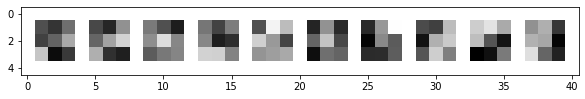

Visualization filters learned for layer: layer2


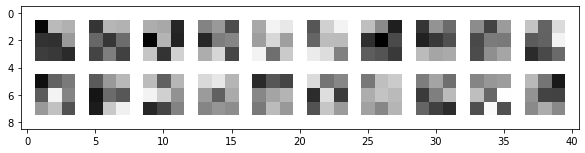

In [0]:
print('No binary model with stride')
viz_filters(model_no_binary_stride, nrow)

Binary model with stride
Visualization filters learned for layer: layer1


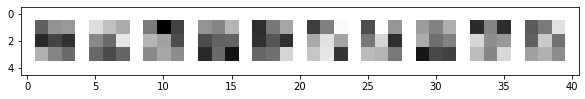

Visualization filters learned for layer: layer2


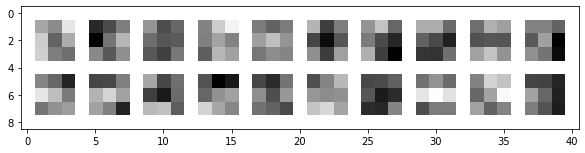

In [0]:
print('Binary model with stride')
viz_filters(model_binary_stride, nrow)

Mixt model with stride
Visualization filters learned for layer: layer1_no_binary


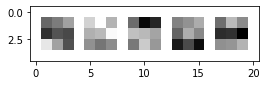

Visualization filters learned for layer: layer1_binary


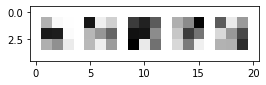

Visualization filters learned for layer: layer2_no_binary


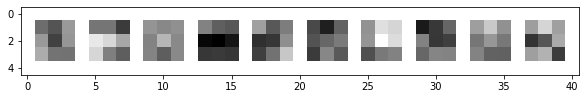

Visualization filters learned for layer: layer2_binary


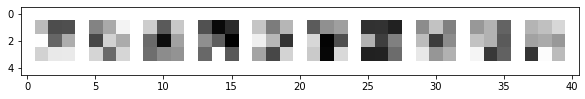

In [0]:
print('Mixt model with stride')
viz_filters(model_mixt_stride, nrow)

No binary model with maxpooling
Visualization filters learned for layer: layer1


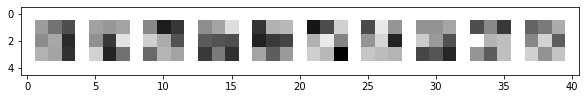

Visualization filters learned for layer: layer2


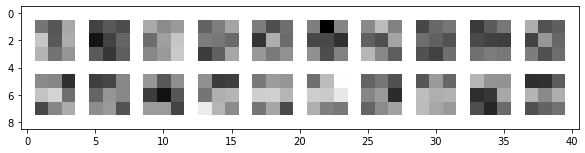

In [0]:
print('No binary model with maxpooling')
viz_filters(model_no_binary_maxpooling, nrow)

Binary model with maxpooling
Visualization filters learned for layer: layer1


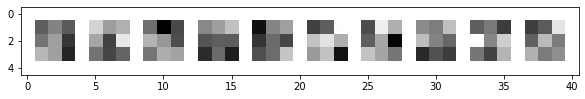

Visualization filters learned for layer: layer2


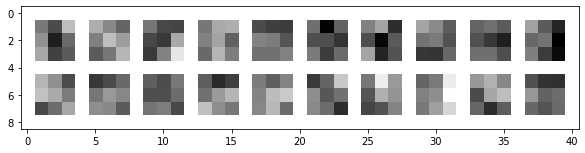

In [0]:
print('Binary model with maxpooling')
viz_filters(model_binary_maxpooling, nrow)

Mixt model with maxpooling
Visualization filters learned for layer: layer1_no_binary


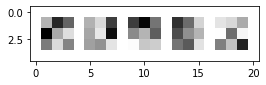

Visualization filters learned for layer: layer1_binary


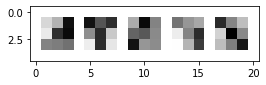

Visualization filters learned for layer: layer2_no_binary


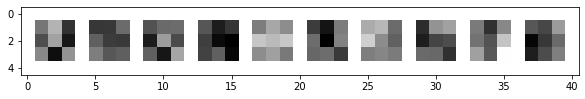

Visualization filters learned for layer: layer2_binary


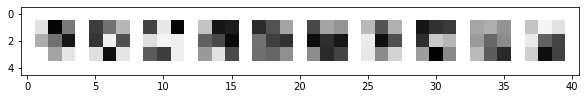

In [0]:
print('Mixt model with maxpooling')
viz_filters(model_mixt_maxpooling, nrow)

## Visualization generated images for activation maximization with gradient a ascent:

Activation maximization is one form of feature visualization that allows us to visualize what CNN filters are "looking for", by applying each filter to an input image and updating the input image so as to maximize the activation of the filter of interest (i.e. treating it as a gradient ascent task with filter activation values as the loss).

In [0]:
# parameters for MNIST data:

MNIST = True

nb_channels=1
img_size=28

conv1_filters = [0,1,2,3,4,5,6,7,8,9]
conv2_filters = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

mean_gradient_layer1 = False
mean_gradient_layer2 = False

ind_x_layer1 = 7
ind_y_layer1 = 7

ind_x_layer2 = 3
ind_y_layer2 = 3

lr = 0.001
num_iter = 100

### No binary model:

#### With stride:

In [0]:
g_ascent_no_binary_stride = GradientAscent(model_no_binary_stride, nb_channels=nb_channels, img_size=img_size)
g_ascent_no_binary_stride.use_gpu = True

In [0]:
conv1_no_binary_stride = model_no_binary_stride.layer1
conv2_no_binary_stride = model_no_binary_stride.layer2

In [0]:
g_ascent_no_binary_stride.visualize(conv1_no_binary_stride, MNIST, conv1_filters, mean_gradient_layer1,
                             ind_x_layer1, ind_y_layer1, lr=lr, num_iter=num_iter, title='No binary with stride model: conv layer 1')
g_ascent_no_binary_stride.visualize(conv2_no_binary_stride, MNIST, conv2_filters, mean_gradient_layer2,
                             ind_x_layer2, ind_y_layer2, lr=lr, num_iter=num_iter, title='No binary with stride model: conv layer 2')

#### With maxpooling:

In [0]:
g_ascent_no_binary_maxpooling = GradientAscent(model_no_binary_maxpooling, nb_channels=nb_channels, img_size=img_size)
g_ascent_no_binary_maxpooling.use_gpu = True

In [0]:
conv1_no_binary_maxpooling = model_no_binary_maxpooling.layer1
conv2_no_binary_maxpooling = model_no_binary_maxpooling.layer2

In [0]:
g_ascent_no_binary_maxpooling.visualize(conv1_no_binary_maxpooling, MNIST, conv1_filters, mean_gradient_layer1,
                             ind_x_layer1, ind_y_layer1, lr=lr, num_iter=num_iter, title='No binary with maxpooling model: conv layer 1')
g_ascent_no_binary_maxpooling.visualize(conv2_no_binary_maxpooling, MNIST, conv2_filters, mean_gradient_layer2,
                             ind_x_layer2, ind_y_layer2, lr=lr, num_iter=num_iter, title='No binary with maxpooling model: conv layer 2')

### Binary model:

#### With stride:

In [0]:
g_ascent_binary_stride = GradientAscent(model_binary_stride, nb_channels=nb_channels, img_size=img_size)
g_ascent_binary_stride.use_gpu = True

In [0]:
conv1_binary_stride = model_binary_stride.layer1
conv2_binary_stride = model_binary_stride.layer2

In [0]:
g_ascent_binary_stride.visualize(conv1_binary_stride, MNIST, conv1_filters, mean_gradient_layer1,
                             ind_x_layer1, ind_y_layer1, lr=lr, num_iter=num_iter, title='Binary with stride model: conv layer 1')
g_ascent_binary_stride.visualize(conv2_binary_stride, MNIST, conv2_filters, mean_gradient_layer2,
                             ind_x_layer2, ind_y_layer2, lr=lr, num_iter=num_iter, title='Binary with stride model: conv layer 2')

#### With Maxpooling:

In [0]:
g_ascent_binary_maxpooling = GradientAscent(model_binary_maxpooling, nb_channels=nb_channels, img_size=img_size)
g_ascent_binary_maxpooling.use_gpu = True

In [0]:
conv1_binary_maxpooling = model_binary_maxpooling.layer1
conv2_binary_maxpooling = model_binary_maxpooling.layer2

In [0]:
g_ascent_binary_maxpooling.visualize(conv1_binary_maxpooling, MNIST, conv1_filters, mean_gradient_layer1,
                             ind_x_layer1, ind_y_layer1, lr=lr, num_iter=num_iter, title='Binary with maxpooling model: conv layer 1')
g_ascent_binary_maxpooling.visualize(conv2_binary_maxpooling, MNIST, conv2_filters, mean_gradient_layer2,
                             ind_x_layer2, ind_y_layer2, lr=lr, num_iter=num_iter, title='Binary with maxpooling model: conv layer 2')

### Mixt model:

#### With stride:

In [0]:
g_ascent_mixt_stride = GradientAscent(model_mixt_stride, nb_channels=nb_channels, img_size=img_size)
g_ascent_mixt_stride.use_gpu = True

In [0]:
conv1_mixt_stride = model_mixt_stride.layer1
conv2_mixt_stride = model_mixt_stride.layer2

In [0]:
g_ascent_mixt_stride.visualize(conv1_mixt_stride, MNIST, conv1_filters, mean_gradient_layer1,
                             ind_x_layer1, ind_y_layer1, lr=lr, num_iter=num_iter, title='Mixt with stride model: conv layer 1')
g_ascent_mixt_stride.visualize(conv2_mixt_stride, MNIST, conv2_filters, mean_gradient_layer2,
                             ind_x_layer2, ind_y_layer2, lr=lr, num_iter=num_iter, title='Mixt with stride model: conv layer 2')

#### With Maxpooling:

In [0]:
g_ascent_mixt_maxpooling = GradientAscent(model_mixt_maxpooling, nb_channels=nb_channels, img_size=img_size)
g_ascent_mixt_maxpooling.use_gpu = True

In [0]:
conv1_mixt_maxpooling = model_mixt_maxpooling.layer1
conv2_mixt_maxpooling = model_mixt_maxpooling.layer2

In [0]:
g_ascent_mixt_maxpooling.visualize(conv1_mixt_maxpooling, MNIST, conv1_filters, mean_gradient_layer1,
                             ind_x_layer1, ind_y_layer1, lr=lr, num_iter=num_iter, title='Mixt with maxpooling model: conv layer 1')
g_ascent_mixt_maxpooling.visualize(conv2_mixt_maxpooling, MNIST, conv2_filters, mean_gradient_layer2,
                             ind_x_layer2, ind_y_layer2, lr=lr, num_iter=num_iter, title='Mixt with maxpooling model: conv layer 2')

# Visualize Regions that maximized filters:

## Load regions, activations and regions means:

In [0]:
# Labels:
labels = np.load('results/MNIST_results/MNIST_regions/labels.npy', allow_pickle=True)

# No binary model with stride:
region_layer1_no_binary_stride = np.load('results/MNIST_results/MNIST_regions/No_binary_model/stride/regions_max_layer1.npy', allow_pickle=True)
region_layer2_no_binary_stride = np.load('results/MNIST_results/MNIST_regions/No_binary_model/stride/regions_max_layer2.npy', allow_pickle=True)
activation_layer1_no_binary_stride = np.load('results/MNIST_results/MNIST_regions/No_binary_model/stride/activations_max_layer1.npy', allow_pickle=True)
activation_layer2_no_binary_stride = np.load('results/MNIST_results/MNIST_regions/No_binary_model/stride/activations_max_layer2.npy', allow_pickle=True)
activation_layer1_no_binary_normalized_stride = np.load('results/MNIST_results/MNIST_regions/No_binary_model/stride/activations_max_layer1_normalized.npy', allow_pickle=True)
activation_layer2_no_binary_normalized_stride = np.load('results/MNIST_results/MNIST_regions/No_binary_model/stride/activations_max_layer2_normalized.npy', allow_pickle=True)

# No binary model with maxpooling:
region_layer1_no_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/No_binary_model/maxpooling/regions_max_layer1.npy', allow_pickle=True)
region_layer2_no_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/No_binary_model/maxpooling/regions_max_layer2.npy', allow_pickle=True)
activation_layer1_no_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/No_binary_model/maxpooling/activations_max_layer1.npy', allow_pickle=True)
activation_layer2_no_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/No_binary_model/maxpooling/activations_max_layer2.npy', allow_pickle=True)
activation_layer1_no_binary_normalized_maxpooling = np.load('results/MNIST_results/MNIST_regions/No_binary_model/maxpooling/activations_max_layer1_normalized.npy', allow_pickle=True)
activation_layer2_no_binary_normalized_maxpooling = np.load('results/MNIST_results/MNIST_regions/No_binary_model/maxpooling/activations_max_layer2_normalized.npy', allow_pickle=True)

# Binary model with stride:
region_layer1_binary_stride = np.load('results/MNIST_results/MNIST_regions/Binary_model/stride/regions_max_layer1.npy', allow_pickle=True)
region_layer2_binary_stride = np.load('results/MNIST_results/MNIST_regions/Binary_model/stride/regions_max_layer2.npy', allow_pickle=True)
activation_layer1_binary_stride = np.load('results/MNIST_results/MNIST_regions/Binary_model/stride/activations_max_layer1.npy', allow_pickle=True)
activation_layer2_binary_stride = np.load('results/MNIST_results/MNIST_regions/Binary_model/stride/activations_max_layer2.npy', allow_pickle=True)
activation_layer1_binary_normalized_stride = np.load('results/MNIST_results/MNIST_regions/Binary_model/stride/activations_max_layer1_normalized.npy', allow_pickle=True)
activation_layer2_binary_normalized_stride = np.load('results/MNIST_results/MNIST_regions/Binary_model/stride/activations_max_layer2_normalized.npy', allow_pickle=True)

# Binary model with maxpooling:
region_layer1_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/Binary_model/maxpooling/regions_max_layer1.npy', allow_pickle=True)
region_layer2_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/Binary_model/maxpooling/regions_max_layer2.npy', allow_pickle=True)
activation_layer1_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/Binary_model/maxpooling/activations_max_layer1.npy', allow_pickle=True)
activation_layer2_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/Binary_model/maxpooling/activations_max_layer2.npy', allow_pickle=True)
activation_layer1_binary_normalized_maxpooling = np.load('results/MNIST_results/MNIST_regions/Binary_model/maxpooling/activations_max_layer1_normalized.npy', allow_pickle=True)
activation_layer2_binary_normalized_maxpooling = np.load('results/MNIST_results/MNIST_regions/Binary_model/maxpooling/activations_max_layer2_normalized.npy', allow_pickle=True)

# Mixt model no binary with stride:
region_layer1_mixt_no_binary_stride = np.load('results/MNIST_results/MNIST_regions/Mixt_model/stride/regions_max_layer1_no_binary.npy', allow_pickle=True)
region_layer2_mixt_no_binary_stride = np.load('results/MNIST_results/MNIST_regions/Mixt_model/stride/regions_max_layer2_no_binary.npy', allow_pickle=True)
activation_layer1_mixt_no_binary_stride = np.load('results/MNIST_results/MNIST_regions/Mixt_model/stride/activations_max_layer1_no_binary.npy', allow_pickle=True)
activation_layer2_mixt_no_binary_stride = np.load('results/MNIST_results/MNIST_regions/Mixt_model/stride/activations_max_layer2_no_binary.npy', allow_pickle=True)
activation_layer1_mixt_no_binary_normalized_stride = np.load('results/MNIST_results/MNIST_regions/Mixt_model/stride/activations_max_layer1_no_binary_normalized.npy', allow_pickle=True)
activation_layer2_mixt_no_binary_normalized_stride = np.load('results/MNIST_results/MNIST_regions/Mixt_model/stride/activations_max_layer2_no_binary_normalized.npy', allow_pickle=True)

# Mixt model binary with stride:
region_layer1_mixt_binary_stride = np.load('results/MNIST_results/MNIST_regions/Mixt_model/stride/regions_max_layer1_binary.npy', allow_pickle=True)
region_layer2_mixt_binary_stride = np.load('results/MNIST_results/MNIST_regions/Mixt_model/stride/regions_max_layer2_binary.npy', allow_pickle=True)
activation_layer1_mixt_binary_stride = np.load('results/MNIST_results/MNIST_regions/Mixt_model/stride/activations_max_layer1_binary.npy', allow_pickle=True)
activation_layer2_mixt_binary_stride = np.load('results/MNIST_results/MNIST_regions/Mixt_model/stride/activations_max_layer2_binary.npy', allow_pickle=True)
activation_layer1_mixt_binary_normalized_stride = np.load('results/MNIST_results/MNIST_regions/Mixt_model/stride/activations_max_layer1_binary_normalized.npy', allow_pickle=True)
activation_layer2_mixt_binary_normalized_stride = np.load('results/MNIST_results/MNIST_regions/Mixt_model/stride/activations_max_layer2_binary_normalized.npy', allow_pickle=True)

# Mixt model no binary with maxpooling:
region_layer1_mixt_no_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/Mixt_model/maxpooling/regions_max_layer1_no_binary.npy', allow_pickle=True)
region_layer2_mixt_no_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/Mixt_model/maxpooling/regions_max_layer2_no_binary.npy', allow_pickle=True)
activation_layer1_mixt_no_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/Mixt_model/maxpooling/activations_max_layer1_no_binary.npy', allow_pickle=True)
activation_layer2_mixt_no_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/Mixt_model/maxpooling/activations_max_layer2_no_binary.npy', allow_pickle=True)
activation_layer1_mixt_no_binary_normalized_maxpooling = np.load('results/MNIST_results/MNIST_regions/Mixt_model/maxpooling/activations_max_layer1_no_binary_normalized.npy', allow_pickle=True)
activation_layer2_mixt_no_binary_normalized_maxpooling = np.load('results/MNIST_results/MNIST_regions/Mixt_model/maxpooling/activations_max_layer2_no_binary_normalized.npy', allow_pickle=True)

# Mixt model binary with maxpooling:
region_layer1_mixt_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/Mixt_model/maxpooling/regions_max_layer1_binary.npy', allow_pickle=True)
region_layer2_mixt_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/Mixt_model/maxpooling/regions_max_layer2_binary.npy', allow_pickle=True)
activation_layer1_mixt_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/Mixt_model/maxpooling/activations_max_layer1_binary.npy', allow_pickle=True)
activation_layer2_mixt_binary_maxpooling = np.load('results/MNIST_results/MNIST_regions/Mixt_model/maxpooling/activations_max_layer2_binary.npy', allow_pickle=True)
activation_layer1_mixt_binary_normalized_maxpooling = np.load('results/MNIST_results/MNIST_regions/Mixt_model/maxpooling/activations_max_layer1_binary_normalized.npy', allow_pickle=True)
activation_layer2_mixt_binary_normalized_maxpooling = np.load('results/MNIST_results/MNIST_regions/Mixt_model/maxpooling/activations_max_layer2_binary_normalized.npy', allow_pickle=True)

## Visualize regions details:

In [0]:
# parameters
list_filter_interest_layer1 = range(10)
list_filter_interest_layer2 = range(20)
list_filter_interest_layer1_mixt = range(5)
list_filter_interest_layer2_mixt = range(10)

best = True
worst = False
viz_mean_img = True
viz_grid = True
plot_histogram = False
details = True

percentage = 10
nrow=14

In [0]:
# regions and activation of interest
list_filter = list_filter_interest_layer1
regions = region_layer1_no_binary_stride
activations = activation_layer1_no_binary_stride
activations_normalized = activation_layer1_no_binary_normalized_stride

In [0]:
selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best, worst, viz_mean_img, viz_grid, percentage, list_filter, nrow=nrow, plot_histogram=plot_histogram)

## Visualize regions resume:

In [0]:
# parameters:
list_filter_interest_layer1 = range(10)
list_filter_interest_layer2 = range(20)
list_filter_interest_layer1_mixt = range(5)
list_filter_interest_layer2_mixt = range(10)

best = True
worst = False
viz_mean_img = True
viz_grid = False
plot_histogram = False
details = False

percentage = 10
nrow=14

### No binary model with stride:

Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


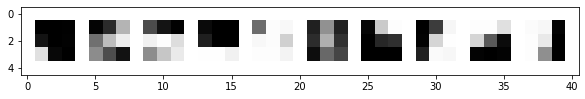

With normalized activations:


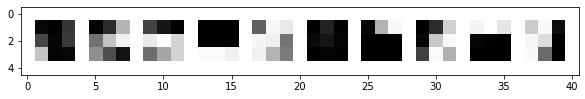

Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


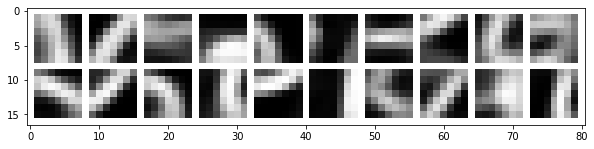

With normalized activations:


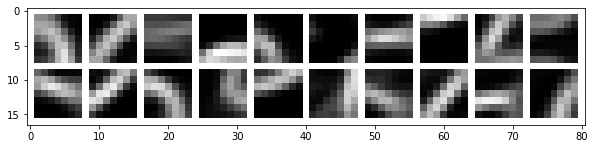

In [0]:
# regions and activation of interest
list_filter = list_filter_interest_layer1
regions = region_layer1_no_binary_stride
activations = activation_layer1_no_binary_stride
activations_normalized = activation_layer1_no_binary_normalized_stride

selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

list_filter = list_filter_interest_layer2
regions = region_layer2_no_binary_stride
activations = activation_layer2_no_binary_stride
activations_normalized = activation_layer2_no_binary_normalized_stride

# regions and activation of interest
list_filter = list_filter_interest_layer2
regions = region_layer2_no_binary_stride
activations = activation_layer2_no_binary_stride
activations_normalized = activation_layer2_no_binary_normalized_stride

selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

No binary model with stride
Visualization filters learned for layer: layer1


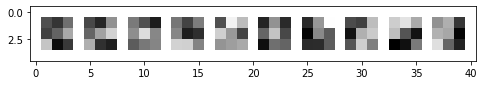

Visualization filters learned for layer: layer2


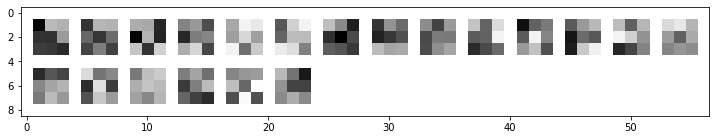

In [0]:
print('No binary model with stride')
viz_filters(model_no_binary_stride, nrow)

### No binary model with maxpooling:

Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


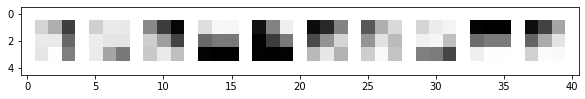

With normalized activations:


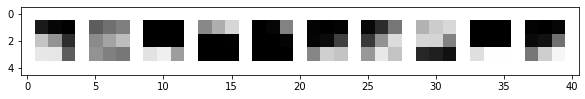

Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


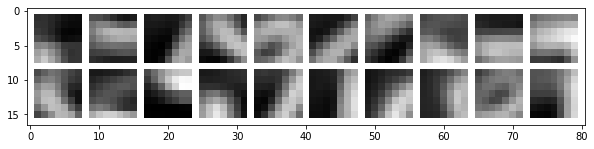

With normalized activations:


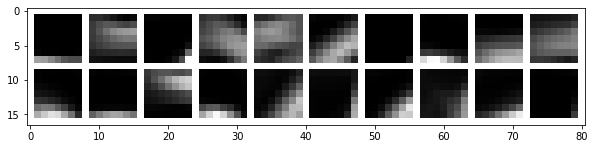

In [0]:
list_filter = list_filter_interest_layer1
regions = region_layer1_no_binary_maxpooling
activations = activation_layer1_no_binary_maxpooling
activations_normalized = activation_layer1_no_binary_normalized_maxpooling

selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

list_filter = list_filter_interest_layer2
regions = region_layer2_no_binary_maxpooling
activations = activation_layer2_no_binary_maxpooling
activations_normalized = activation_layer2_no_binary_normalized_maxpooling

selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

No binary model with maxpooling
Visualization filters learned for layer: layer1


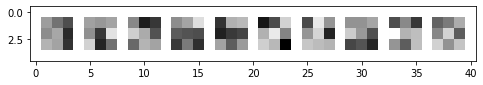

Visualization filters learned for layer: layer2


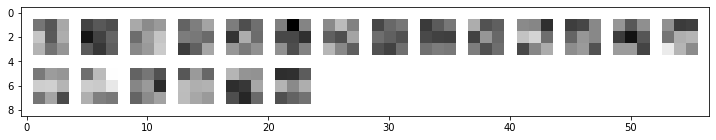

In [0]:
print('No binary model with maxpooling')
viz_filters(model_no_binary_maxpooling, nrow)

### Binary model with stride:

Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


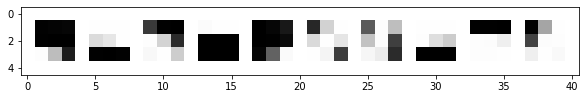

With normalized activations:


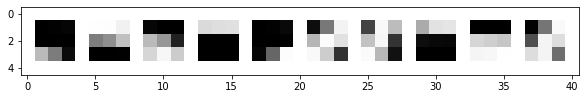

Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


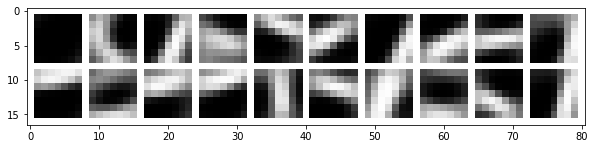

With normalized activations:


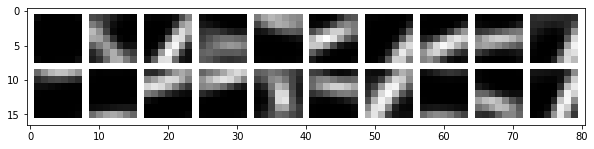

In [0]:
list_filter = list_filter_interest_layer1
regions = region_layer1_binary_stride
activations = activation_layer1_binary_stride
activations_normalized = activation_layer1_binary_normalized_stride

selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

list_filter = list_filter_interest_layer2
regions = region_layer2_binary_stride
activations = activation_layer2_binary_stride
activations_normalized = activation_layer2_binary_normalized_stride

selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

Binary model with stride
Visualization filters learned for layer: layer1


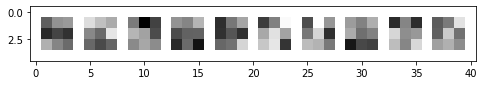

Visualization filters learned for layer: layer2


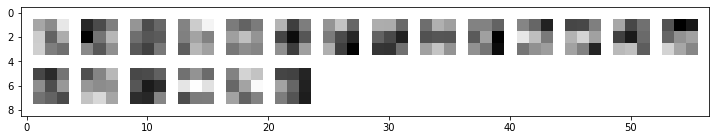

In [0]:
print('Binary model with stride')
viz_filters(model_binary_stride, nrow)

### Binary model with maxpooling:

Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


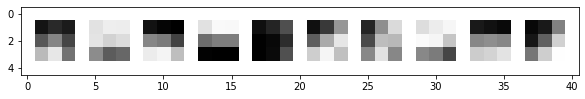

With normalized activations:


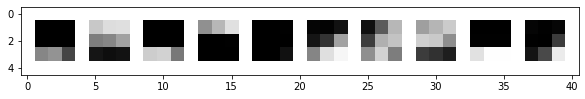

Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


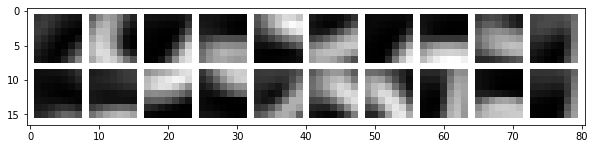

With normalized activations:


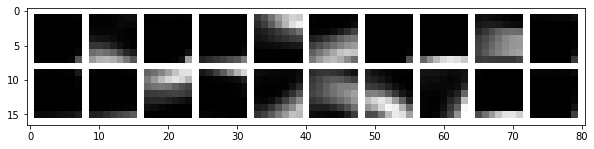

In [0]:
list_filter = list_filter_interest_layer1
regions = region_layer1_binary_maxpooling
activations = activation_layer1_binary_maxpooling
activations_normalized = activation_layer1_binary_normalized_maxpooling

selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

list_filter = list_filter_interest_layer2
regions = region_layer2_binary_maxpooling
activations = activation_layer2_binary_maxpooling
activations_normalized = activation_layer2_binary_normalized_maxpooling

selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

Binary model with maxpooling
Visualization filters learned for layer: layer1


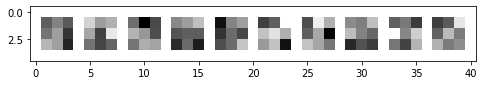

Visualization filters learned for layer: layer2


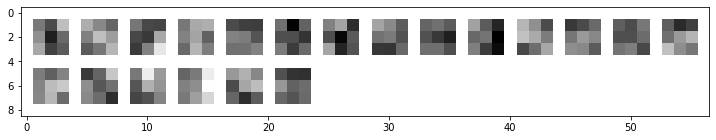

In [0]:
print('Binary model with maxpooling')
viz_filters(model_binary_maxpooling, nrow)

### Mixt model with stride:

mixt model no binary stride layer 1:
Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


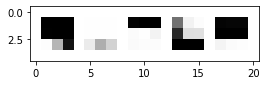

With normalized activations:


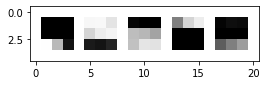

mixt model binary stride layer 1:
Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


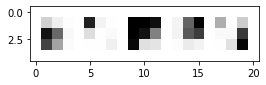

With normalized activations:


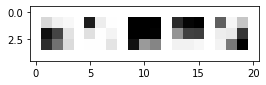

mixt model no binary stride layer 2:
Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


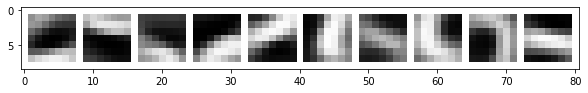

With normalized activations:


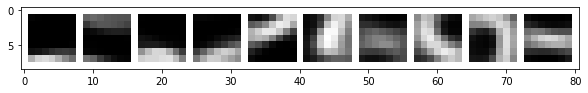

mixt model binary stride layer 2:
Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


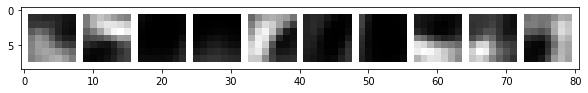

With normalized activations:


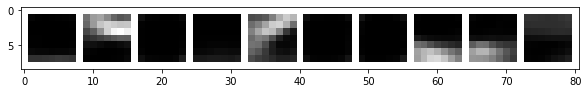

In [0]:
list_filter = list_filter_interest_layer1_mixt
regions = region_layer1_mixt_no_binary_stride
activations = activation_layer1_mixt_no_binary_stride
activations_normalized = activation_layer1_mixt_no_binary_normalized_stride
print('mixt model no binary stride layer 1:')
selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

regions = region_layer1_mixt_binary_stride
activations = activation_layer1_mixt_binary_stride
activations_normalized = activation_layer1_mixt_binary_normalized_stride
print('mixt model binary stride layer 1:')
selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)


list_filter = list_filter_interest_layer2_mixt
regions = region_layer2_mixt_no_binary_stride
activations = activation_layer2_mixt_no_binary_stride
activations_normalized = activation_layer2_mixt_no_binary_normalized_stride
print('mixt model no binary stride layer 2:')
selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

regions = region_layer2_mixt_binary_stride
activations = activation_layer2_mixt_binary_stride
activations_normalized = activation_layer2_mixt_binary_normalized_stride
print('mixt model binary stride layer 2:')
selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

Mixt model with stride
Visualization filters learned for layer: layer1_no_binary


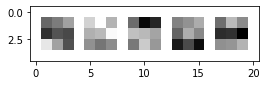

Visualization filters learned for layer: layer1_binary


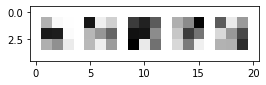

Visualization filters learned for layer: layer2_no_binary


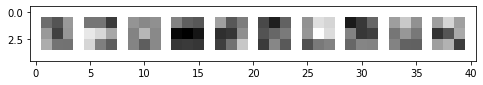

Visualization filters learned for layer: layer2_binary


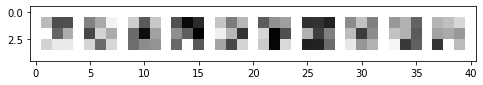

In [0]:
print('Mixt model with stride')
viz_filters(model_mixt_stride, nrow)

### Mixt model with maxpooling:

mixt model no binary maxpooling layer 1:
Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


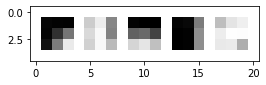

With normalized activations:


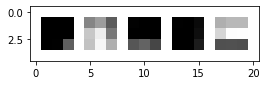

mixt model binary maxpooling layer 1:
Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


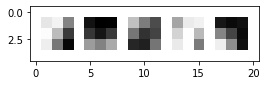

With normalized activations:


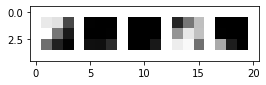

mixt model no binary maxpooling layer 2:
Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


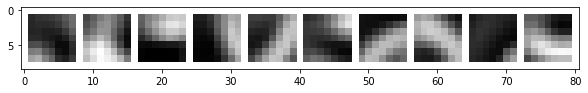

With normalized activations:


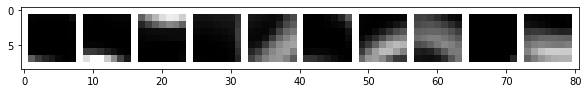

mixt model binary maxpooling layer 2:
Consider 10% image regions = 1000 images
mean regions of 1000 regions who activate most filters:


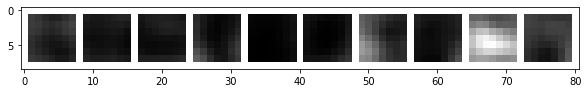

With normalized activations:


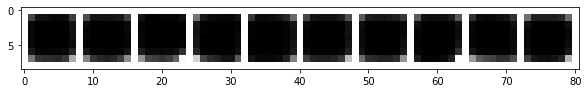

In [0]:
list_filter = list_filter_interest_layer1_mixt
regions = region_layer1_mixt_no_binary_maxpooling
activations = activation_layer1_mixt_no_binary_maxpooling
activations_normalized = activation_layer1_mixt_no_binary_normalized_maxpooling
print('mixt model no binary maxpooling layer 1:')
selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

list_filter = list_filter_interest_layer1_mixt
regions = region_layer1_mixt_binary_maxpooling
activations = activation_layer1_mixt_binary_maxpooling
activations_normalized = activation_layer1_mixt_binary_normalized_maxpooling
print('mixt model binary maxpooling layer 1:')
selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

list_filter = list_filter_interest_layer2_mixt
regions = region_layer2_mixt_no_binary_maxpooling
activations = activation_layer2_mixt_no_binary_maxpooling
activations_normalized = activation_layer2_mixt_no_binary_normalized_maxpooling
print('mixt model no binary maxpooling layer 2:')
selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

regions = region_layer2_mixt_binary_maxpooling
activations = activation_layer2_mixt_binary_maxpooling
activations_normalized = activation_layer2_mixt_binary_normalized_maxpooling
print('mixt model binary maxpooling layer 2:')
selected_regions, activation_values, activation_values_normalized = get_regions_interest(regions, labels, activations, activations_normalized, details=details, best=best, worst=worst, viz_mean_img=viz_mean_img, viz_grid=viz_grid, percentage=percentage, list_filter=list_filter, nrow=nrow, plot_histogram=plot_histogram)

Mixt model with maxpooling
Visualization filters learned for layer: layer1_no_binary


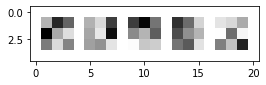

Visualization filters learned for layer: layer1_binary


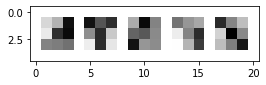

Visualization filters learned for layer: layer2_no_binary


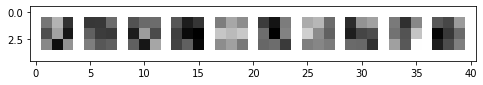

Visualization filters learned for layer: layer2_binary


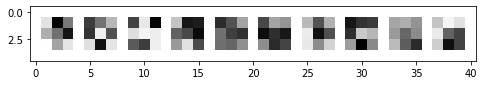

In [0]:
print('Mixt model with maxpooling')
viz_filters(model_mixt_maxpooling, nrow)

## Histograms:

(array([ 969.,    0., 1137.,    0.,  966.,    0., 1067.,    0.,  970.,
           0.,    0.,  925.,    0.,  946.,    0., 1043.,    0.,  943.,
           0., 1034.]),
 array([0.  , 0.45, 0.9 , 1.35, 1.8 , 2.25, 2.7 , 3.15, 3.6 , 4.05, 4.5 ,
        4.95, 5.4 , 5.85, 6.3 , 6.75, 7.2 , 7.65, 8.1 , 8.55, 9.  ]),
 <a list of 20 Patch objects>)

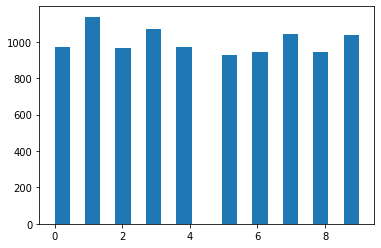

In [0]:
plt.hist(labels, bins=20)

In [0]:
# get histograms:
activation = None
activations_normalized = None
list_filter = range(10)  # or 20
best = True
percentage = 10
return_values = True
plot = False

In [0]:
_, labels_selected, labels_selected_normalized, labels_selected_all, labels_selected_all_normalized = get_labels_histogram(labels, activation, activations_normalized, list_filter=list_filter, best=best, percentage=percentage, plot=plot, return_values=return_values)

### Compare two histograms:

In [0]:
x = None
y = None
label_x = 'title x'
label_y ='title 2'

bins = np.linspace(0, 10, 20)

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.hist([x, y], bins, alpha=0.75, label=[label_x, label_y])
plt.legend(loc='upper right')
plt.title('Title')
plt.show()

# One nearest neighbor:

## Sort dataset per classes:

In [12]:
# get images sorted by classes
dataiter = iter(train_loader)
images, labels = dataiter.next()

sort_images = []
for i in range(10):
  classe=i
  idx = labels==classe
  sort_images.append(images[idx])

labels = range(10)
for i in range(10):
  print(sort_images[i].shape, labels[i])

torch.Size([5313, 1, 28, 28]) 0
torch.Size([6072, 1, 28, 28]) 1
torch.Size([5387, 1, 28, 28]) 2
torch.Size([5540, 1, 28, 28]) 3
torch.Size([5264, 1, 28, 28]) 4
torch.Size([4883, 1, 28, 28]) 5
torch.Size([5323, 1, 28, 28]) 6
torch.Size([5643, 1, 28, 28]) 7
torch.Size([5253, 1, 28, 28]) 8
torch.Size([5322, 1, 28, 28]) 9


In [0]:
for i in range(10):
  np.save('results/MNIST_results/dataset_sorted/MNIST_dataset_classe_' + str(i) + '.npy', sort_images[i])

## Load MNIST dataset sorted:

In [18]:
MNIST_dataset_classe_0 = np.load('results/MNIST_results/dataset_sorted/MNIST_dataset_classe_0.npy', allow_pickle=True)
MNIST_dataset_classe_1 = np.load('results/MNIST_results/dataset_sorted/MNIST_dataset_classe_1.npy', allow_pickle=True)
MNIST_dataset_classe_2 = np.load('results/MNIST_results/dataset_sorted/MNIST_dataset_classe_2.npy', allow_pickle=True)
MNIST_dataset_classe_3 = np.load('results/MNIST_results/dataset_sorted/MNIST_dataset_classe_3.npy', allow_pickle=True)
MNIST_dataset_classe_4 = np.load('results/MNIST_results/dataset_sorted/MNIST_dataset_classe_4.npy', allow_pickle=True)
MNIST_dataset_classe_5 = np.load('results/MNIST_results/dataset_sorted/MNIST_dataset_classe_5.npy', allow_pickle=True)
MNIST_dataset_classe_6 = np.load('results/MNIST_results/dataset_sorted/MNIST_dataset_classe_6.npy', allow_pickle=True)
MNIST_dataset_classe_7 = np.load('results/MNIST_results/dataset_sorted/MNIST_dataset_classe_7.npy', allow_pickle=True)
MNIST_dataset_classe_8 = np.load('results/MNIST_results/dataset_sorted/MNIST_dataset_classe_8.npy', allow_pickle=True)
MNIST_dataset_classe_9 = np.load('results/MNIST_results/dataset_sorted/MNIST_dataset_classe_9.npy', allow_pickle=True)

print(MNIST_dataset_classe_0.shape)
print(MNIST_dataset_classe_1.shape)
print(MNIST_dataset_classe_2.shape)
print(MNIST_dataset_classe_3.shape)
print(MNIST_dataset_classe_4.shape)
print(MNIST_dataset_classe_5.shape)
print(MNIST_dataset_classe_6.shape)
print(MNIST_dataset_classe_7.shape)
print(MNIST_dataset_classe_8.shape)
print(MNIST_dataset_classe_9.shape)

(5313, 1, 28, 28)
(6072, 1, 28, 28)
(5387, 1, 28, 28)
(5540, 1, 28, 28)
(5264, 1, 28, 28)
(4883, 1, 28, 28)
(5323, 1, 28, 28)
(5643, 1, 28, 28)
(5253, 1, 28, 28)
(5322, 1, 28, 28)


## No binary model stride:

In [0]:
# a dictionary that keeps saving the representaion
representation_no_binary_stride = collections.defaultdict(list)

def save_representation_no_binary_stride(name, mod, inp, out):
    representation_no_binary_stride[name].append(out.cpu())

In [0]:
# Registering hooks for all the Conv2d layers
# Note: Hooks are called EVERY TIME the module performs a forward pass. For modules that are
# called repeatedly at different stages of the forward pass (like RELUs), this will save different
# activations. Editing the forward pass code to save activations is the way to go for these cases.
for name, m in model_no_binary_stride.named_modules():
    if type(m)==nn.BatchNorm2d:
      m.register_forward_hook(partial(save_representation_no_binary_stride, name))

out = model_no_binary_stride(MNIST_dataset_classe_0])

representation_no_binary_stride = {name: torch.cat(outputs, 0) for name, outputs in representation_no_binary_stride.items()}

# just print out the sizes of the saved activations as a sanity check
for k,v in representation_no_binary_stride.items():
      print (k, v.size())

batchnorm1 torch.Size([5330, 10, 14, 14])
batchnorm2 torch.Size([5330, 20, 7, 7])


In [0]:
representation_one_mnist_layer1 = representation_no_binary_stride['batchnorm1']
representation_one_mnist_layer2 = representation_no_binary_stride['batchnorm2']

print(representation_one_mnist_layer1.shape)
print(representation_one_mnist_layer1.shape)

torch.Size([5330, 10, 14, 14])
torch.Size([5330, 10, 14, 14])


In [0]:
representation_one_mnist_layer1 = representation_one_mnist_layer1[0]

In [0]:
print(representation_one_mnist_layer1.shape)

torch.Size([10, 14, 14])


In [0]:
representation_one_mnist_layer1 = representation_one_mnist_layer1.view(representation_one_mnist_layer1.size(0), -1)

In [0]:
print(representation_one_mnist_layer1.shape)

torch.Size([10, 196])


In [0]:
#TODO: sous quelle forme les réduire ? en quelle taille ? a quoi correspond exactmeent la shape ?